# Finetuning the LSTM model architecture, then hyperparameters

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from utils.set_seed import set_seed
from utils.load_data import load_and_split_data
from models.lstm import LSTMClassifier
%load_ext autoreload

Data Prep, we're using some mRNA trajectories that have the same mean, variance and autocorrelations

In [2]:
# Read in accuracy data, checking which obe we want
df_acc_results = pd.read_csv("data/accuracy_results_03_04_2025.csv")
df_acc_results[df_acc_results['Variance Ratio'] == 0.9999999999999996]

,Parameter Sets,Stats,Variance Ratio,SVM (rbf) Accuracy,SVM (linear) Accuracy,Random Forest Accuracy,Logistic Regression Accuracy,MLP Accuracy,Random Classifier Accuracy
900,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.799274809160305, 'Stresse...",1.0,0.4125,0.4625,0.5,0.5000,0.5000,0.45
901,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
902,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
903,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
904,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
905,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
906,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
907,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
908,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45
909,"[{'sigma_u': 18.0, 'sigma_b': 0.05910239842116...","({'Stressed Mean': 9.933778625954199, 'Stresse...",1.0,0.4000,0.4750,0.5,0.4875,0.4375,0.45


In [3]:
# Train LSTM model using SSA data
output_file = '/home/ianyang/stochastic_simulations/notebooks/data/mRNA_trajectories_variance_1199_1200/m_traj_1199.9999999999995_1200.0_0.csv'
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data(output_file, split_val_size=0.2) # we must define split_val_size here to get a validation set
# Standardize the data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
# Reshape input for LSTM, LSTM expects input in the shape (batch_size, seq_len, num_features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

## LSTM Architecture Experiments:
- Convolutional Layer
- Multi-Head Attention

<span style="color:red">We can set up an experiment notebook to:</span>

Track accuracy across changes

Log and plot per-class performance

Test small vs large models systematically </span>

In [10]:
################# LSTM Model #################
input_size = X_train.shape[2]  # each time step is a single value
hidden_size = 128 # number of LSTM units
num_layers = 3 # number of LSTM layers
output_size = len(torch.unique(y_train_tensor))  # number of classes
dropout_rate = 0.2
learning_rate = 0.01

model = LSTMClassifier(input_size=input_size, hidden_size=hidden_size, 
                       num_layers=num_layers, output_size=output_size,
                       dropout_rate=dropout_rate, learning_rate=learning_rate, optimizer='Adam',bidirectional=True, use_attention=True)

# Train the model
history = model.train_model(train_loader, val_loader=val_loader,
                            epochs=100, patience=10,
                            # save_path='best_lstm_model.pt'
                            )
# Prepare test data
X_test_tensor = torch.tensor(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# Evaluate
test_acc = model.evaluate(test_loader)
print(f"✅ Test accuracy: {test_acc:.4f}")

🔄 Using device: cuda (1 GPUs available)
DEBUG: Optimizer initialized? True
✅ Running on CUDA!
Epoch [1/100], Loss: 0.7243, Train Acc: 0.4961
Validation Acc: 0.5000
Epoch [2/100], Loss: 1.1542, Train Acc: 0.4922
Validation Acc: 0.5000
No improvement (1/10).
Epoch [3/100], Loss: 1.0075, Train Acc: 0.5000
Validation Acc: 0.5000
No improvement (2/10).
Epoch [4/100], Loss: 0.7120, Train Acc: 0.4844
Validation Acc: 0.5000
No improvement (3/10).
Epoch [5/100], Loss: 0.6955, Train Acc: 0.5273
Validation Acc: 0.5000
No improvement (4/10).
Epoch [6/100], Loss: 0.7249, Train Acc: 0.4922
Validation Acc: 0.5000
No improvement (5/10).
Epoch [7/100], Loss: 0.7131, Train Acc: 0.4688
Validation Acc: 0.5469
Epoch [8/100], Loss: 0.7213, Train Acc: 0.4922
Validation Acc: 0.5000
No improvement (1/10).
Epoch [9/100], Loss: 0.7263, Train Acc: 0.4570
Validation Acc: 0.5469
No improvement (2/10).
Epoch [10/100], Loss: 0.6997, Train Acc: 0.4922
Validation Acc: 0.4688
No improvement (3/10).
Epoch [11/100], Loss:

The model performance is quite bad so let's visualise the time series from the two different classes

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectories_by_class(X, y, num_samples=5):
    """
    Plot time series trajectories grouped by their class labels.
    """
    classes = np.unique(y)
    plt.figure(figsize=(12, len(classes) * 2.5))
    
    for i, cls in enumerate(classes):
        indices = np.where(y == cls)[0][:num_samples]
        for j, idx in enumerate(indices):
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.plot(X[idx].squeeze(), label=f'class {cls}', color='C'+str(cls))
            plt.title(f'Class {cls}, Sample {j+1}')
            plt.xticks([]); plt.yticks([])
            if j == 0:
                plt.ylabel(f'Class {cls}')
    
    plt.tight_layout()
    plt.suptitle("mRNA Time Series Trajectories by Class", y=1.02)
    plt.show()


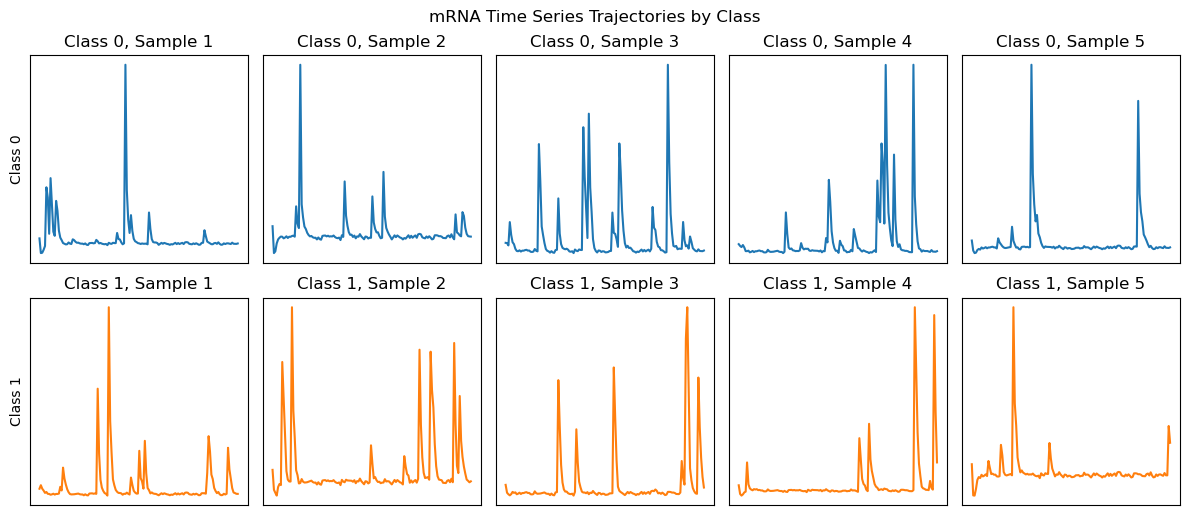

In [31]:
plot_trajectories_by_class(X_train, y_train, num_samples=5)
